<a href="https://colab.research.google.com/github/smccracken13/DataScienceCareerTrack/blob/main/(McCracken)_NBA_Modeling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pre-processing and Training Data Development

The goals of this notebook are to:

1. Create dummies for categorical data ('pos', 'team')
2. create train_test_split
3. standardize the data

# Modeling goals:
1. Review the types of models that would be appropriate given your modeling response and the features in your dataset.
2. build two to three models and identify the best one.
3. implement both an entropy model and a Gini impurity model.
4. For hyperparameter tuning, think of methods like cross-validation
5. use standard model evaluation metrics such as accuracy, recall, precision, and F1.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# load the nba_clean2 dataframe
url = 'https://github.com/smccracken13/NBA-All-Star-Prediction-Project/blob/main/Data/nba_clean2.csv?raw=true'
df = pd.read_csv(url)

Create dummy variables for categorical data

In [3]:
df.select_dtypes(exclude=['int','float']).dtypes

player    object
pos       object
tm        object
dtype: object

In [4]:
# value counts of teams
df['tm'].value_counts()

# value counts of teams for players that were all-stars
df[df['all_star']==1]['tm'].value_counts()

# I am going to drop the team column because I don't see it factoring into all_star selection.
# It was interesting however to see that Lakers are the most represented by quite a bit

LAL    51
SAS    41
UTA    34
HOU    33
PHO    33
PHI    28
BOS    24
GSW    24
DET    23
CHI    23
MIA    21
MIL    19
SEA    19
DAL    17
OKC    17
CLE    16
LAC    16
POR    16
ORL    16
NYK    14
MIN    14
DEN    13
SAC    13
ATL    12
IND    11
TOR     9
NJN     8
WAS     6
NOH     5
CHH     5
TOT     4
MEM     4
NOP     3
WSB     3
BRK     2
CHA     1
CHO     1
KCK     1
Name: tm, dtype: int64

In [5]:
# player and team will not be used in analysis but I would like to keep it for reference
reference_df = df[['season', 'player_id', 'player','tm']]
df = df.drop(['season', 'player_id', 'player','tm'],axis=1)
# drop weird extra columns (don't need this if I fix this issue earlier)
# set seas_id to index
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'],axis=1)
df.set_index('seas_id')

,pos,experience,g,ts_percent,x3p_ar,f_tr,orb_percent,trb_percent,ast_percent,stl_percent,...,ast,stl,blk,tov,pf,pts,all_star,attend,tm_win_percent,seas_avg_attend
seas_id,,,,,,,,,,,,,,,,,,,,,
29646,PF,8,75,0.602,0.312,0.276,6.1,10.3,11.6,0.9,...,188,44.0,44.0,133.0,148,1126,0,695262.000000,0.585366,692948.753846
29647,SF,1,6,0.200,0.200,0.000,0.0,3.3,0.0,0.0,...,0,0.0,2.0,2.0,2,2,0,846867.000000,0.621951,692948.753846
29648,PG,4,63,0.544,0.305,0.201,2.6,6.5,20.7,2.0,...,153,42.0,9.0,67.0,92,400,0,692948.753846,0.500000,692948.753846
29649,PG,4,41,0.547,0.313,0.164,1.5,5.6,17.1,1.8,...,78,24.0,9.0,39.0,60,251,0,641499.000000,0.426829,692948.753846
29650,PG,4,22,0.538,0.290,0.266,4.6,8.2,27.4,2.4,...,75,18.0,0.0,28.0,32,149,0,663171.000000,0.780488,692948.753846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8343,C,12,82,0.545,0.003,0.328,11.2,18.5,15.6,1.0,...,366,65.0,61.0,153.0,249,794,0,588867.333333,0.475610,588867.333333
8344,SF,1,52,0.466,0.012,0.325,11.5,15.6,6.1,1.2,...,33,17.0,23.0,48.0,100,180,0,588867.333333,0.500000,588867.333333
8345,PG,4,62,0.442,0.225,0.165,5.4,6.1,29.3,3.2,...,259,75.0,1.0,95.0,110,299,0,588867.333333,0.451220,588867.333333


In [6]:
# Check categories for position
df['pos'].value_counts()

PF          4384
SG          4245
C           4163
PG          4149
SF          3926
SF-SG         40
SG-SF         33
PG-SG         33
SG-PG         32
PF-C          31
C-PF          31
PF-SF         31
SF-PF         24
SG-PF          4
SG-PG-SF       1
SF-C           1
PG-SF          1
Name: pos, dtype: int64

In [7]:
# one_hot_encode position
df = pd.get_dummies(df, columns=['pos'], prefix='Pos', drop_first=True)

In [8]:
df.head().T

,0,1,2,3,4
seas_id,29646.000000,29647.000000,29648.000000,29649.000000,29650.000000
experience,8.000000,1.000000,4.000000,4.000000,4.000000
g,75.000000,6.000000,63.000000,41.000000,22.000000
ts_percent,0.602000,0.200000,0.544000,0.547000,0.538000
x3p_ar,0.312000,0.200000,0.305000,0.313000,0.290000
f_tr,0.276000,0.000000,0.201000,0.164000,0.266000
orb_percent,6.100000,0.000000,2.600000,1.500000,4.600000
trb_percent,10.300000,3.300000,6.500000,5.600000,8.200000
ast_percent,11.600000,0.000000,20.700000,17.100000,27.400000
stl_percent,0.900000,0.000000,2.000000,1.800000,2.400000


Split into Train and Test sets

In [9]:
# Create train_test_split
X=df.loc[:, df.columns != 'all_star']
y=df['all_star']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

Standardize the data

In [10]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit scaler to the training data
scaler.fit(X_train)

# Transform the train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Modeling goals:
1. Review the types of models that would be appropriate given your modeling response and the features in your dataset.

2. build two to three models and identify the best one.

3. implement both an entropy model and a Gini impurity model.

4. For hyperparameter tuning, think of methods like cross-validation

5. use standard model evaluation metrics such as accuracy, recall, precision, and F1.

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

In [17]:
# create function to output classification reports and confusion matrixes
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def report(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.show()

BASIC RANDOM FOREST CLASSIFIER
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4122
           1       0.80      0.74      0.77       104

    accuracy                           0.99      4226
   macro avg       0.90      0.87      0.88      4226
weighted avg       0.99      0.99      0.99      4226



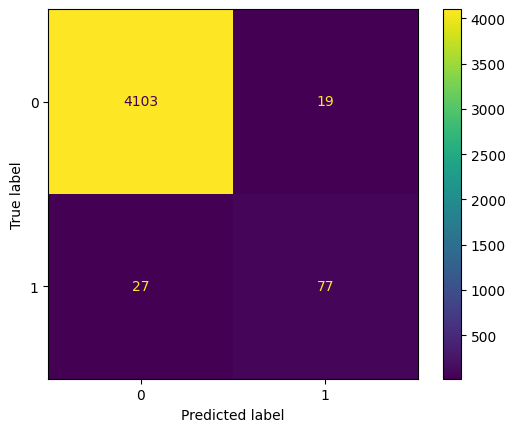

In [18]:
# this is a basic RandomForestClassifier attempt with no tuning
basic_RFC = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
basic_RFC.fit(X_train, y_train)

print("BASIC RANDOM FOREST CLASSIFIER")
report(basic_RFC)

In [19]:
# Using RandomSearchCV to tune hyperparameters for RandomForestClassifier
# Took example from here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [20]:
# Use the random grid to search for best hyperparameters (takes 56 min)
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# A note from my mentor: n_iter argument (100 is too high, maybe 50)
RFC_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
RFC_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [22]:
RFC_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

TUNED RANDOM FOREST CLASSIFIER
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4122
           1       0.80      0.73      0.76       104

    accuracy                           0.99      4226
   macro avg       0.90      0.86      0.88      4226
weighted avg       0.99      0.99      0.99      4226



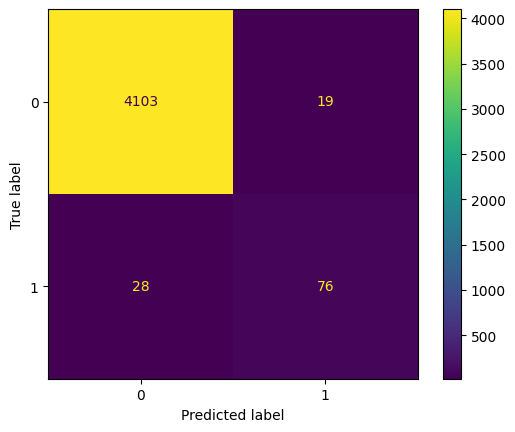

In [23]:
# Run Random Forest Classifier with best hyperparameters
tuned_RFC = RFC_random.best_estimator_
tuned_RFC.fit(X_train, y_train)

print("TUNED RANDOM FOREST CLASSIFIER")
report(tuned_RFC)

TUNED RANDOM FOREST CLASSIFIER
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4122
           1       0.79      0.73      0.76       104

    accuracy                           0.99      4226
   macro avg       0.89      0.86      0.88      4226
weighted avg       0.99      0.99      0.99      4226



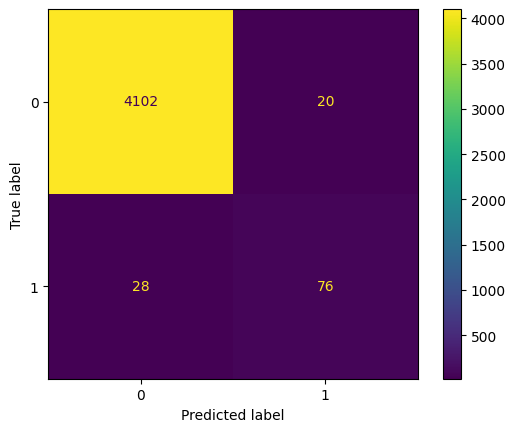

In [25]:
# These were best parameters from 100 n_iter randomsearchCV
RFC3 = RandomForestClassifier(n_estimators=1400, random_state = 1,n_jobs=-1,
                              min_samples_split= 2,
                              min_samples_leaf= 4,
                              max_features= 'sqrt',
                              max_depth= 80,
                              bootstrap= False)
RFC3.fit(X_train, y_train)

print("TUNED RANDOM FOREST CLASSIFIER")
report(RFC3)

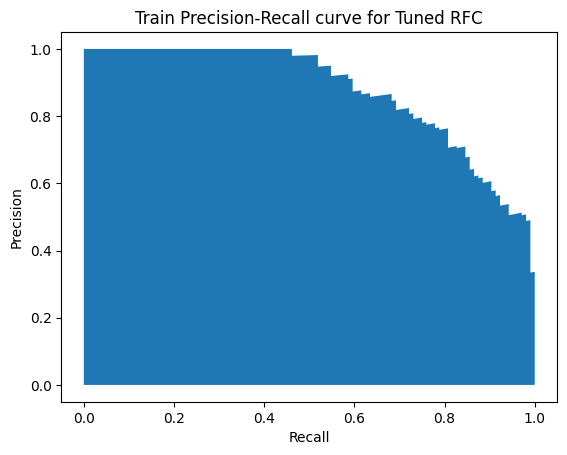

In [27]:
from sklearn.metrics import precision_recall_curve
# y_pred, needs to be probability (check documentation)
y_score = RFC3.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve for Tuned RFC");

My next model will be Logistic Regression, but first I need to deal with class imbalance. I will refer to this article:

https://heartbeat.comet.ml/dealing-with-imbalanced-data-226dc84589c8

In [28]:
# Use SMOTE and Tomek to undersample non all-stars and oversample all-stars
from imblearn.combine import SMOTETomek
smt= SMOTETomek()
X_res, y_res= smt.fit_resample(X_train, y_train)

# LOGISTIC REGRESSION

In [15]:
##build baseline logistic regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='saga')
lr_model.fit(X_res, y_res)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

BASIC LOGISTIC REGRESSION MODEL
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4122
           1       0.39      0.99      0.56       104

    accuracy                           0.96      4226
   macro avg       0.69      0.98      0.77      4226
weighted avg       0.98      0.96      0.97      4226



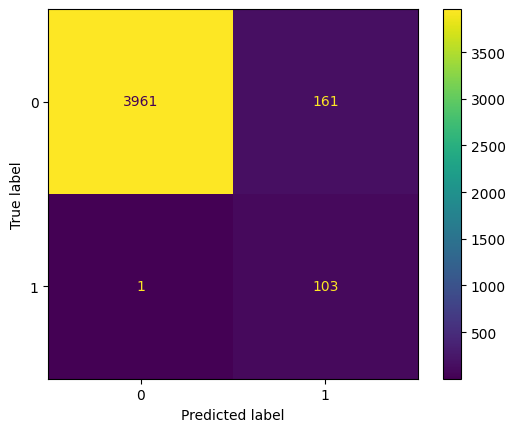

In [29]:
print("BASIC LOGISTIC REGRESSION MODEL")
report(lr_model)

In [30]:
# Use the random grid to search for best hyperparameters
from scipy.stats import uniform
lr = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=1)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_random = RandomizedSearchCV(estimator = lr, param_distributions=distributions, random_state=1, n_jobs = -1)
# Fit the random search model
lr_model_tuned = lr_random.fit(X_train, y_train)
lr_model_tuned.best_params_

{'C': 3.730229437354635, 'penalty': 'l1'}

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TUNED LOGISTIC REGRESSION MODEL
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4122
           1       0.39      0.99      0.56       104

    accuracy                           0.96      4226
   macro avg       0.69      0.98      0.77      4226
weighted avg       0.98      0.96      0.97      4226



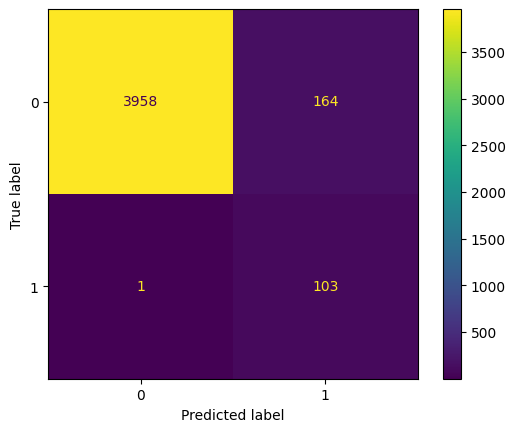

In [31]:
# Run Logistic Regression with best hyperparameters
tuned_lr = LogisticRegression(solver='saga',C=3.730229437354635, penalty='l1')
tuned_lr.fit(X_res, y_res)


print("TUNED LOGISTIC REGRESSION MODEL")
report(tuned_lr)

#Naive Bayes

BASIC NAIVE BAYES MODEL
              precision    recall  f1-score   support

           0       1.00      0.13      0.24      4122
           1       0.03      1.00      0.06       104

    accuracy                           0.16      4226
   macro avg       0.51      0.57      0.15      4226
weighted avg       0.98      0.16      0.23      4226



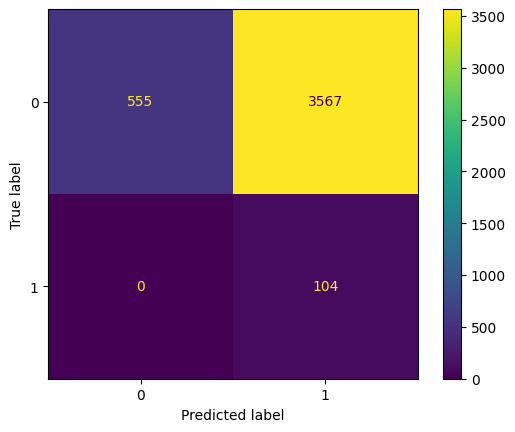

In [32]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
# fit to resampled data
NB.fit(X_res, y_res)

print("BASIC NAIVE BAYES MODEL")
report(NB)

In [33]:
# What hyperparameter tuning should I do for Naive Bayes?
# https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba
from sklearn.model_selection import GridSearchCV
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_res, y_res)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=1.0)


TUNED NAIVE BAYES MODEL
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      4122
           1       0.17      1.00      0.29       104

    accuracy                           0.88      4226
   macro avg       0.58      0.94      0.61      4226
weighted avg       0.98      0.88      0.92      4226



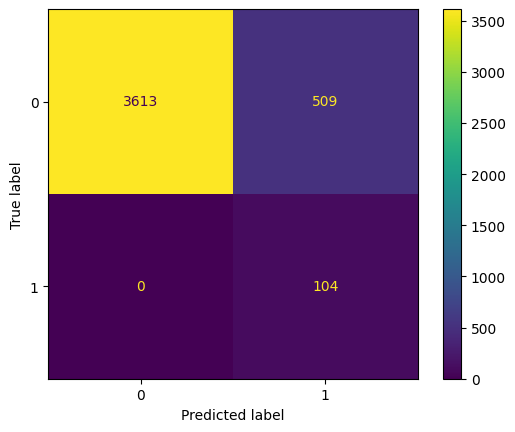

In [34]:
tuned_NB = GaussianNB(var_smoothing=1.0)
tuned_NB.fit(X_res, y_res)

print("TUNED NAIVE BAYES MODEL")
report(tuned_NB)

# SVM


BASIC SVM MODEL
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4122
           1       0.41      0.97      0.58       104

    accuracy                           0.96      4226
   macro avg       0.70      0.97      0.78      4226
weighted avg       0.98      0.96      0.97      4226



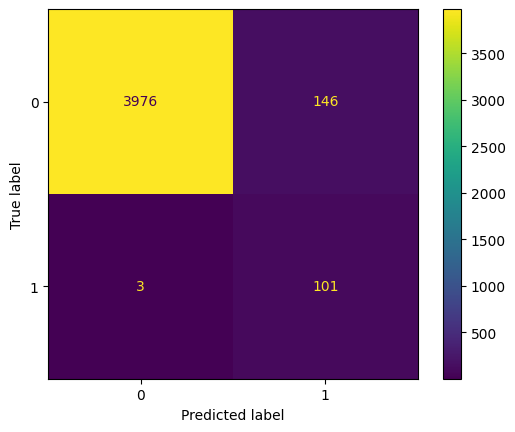

In [35]:
from sklearn import svm
SVM = svm.SVC(kernel= 'linear', random_state=1, C=0.1)
SVM.fit(X_res, y_res)

print("BASIC SVM MODEL")
report(SVM)

In [36]:
# Hyperparameter tuning for SVM
# https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb

from sklearn.model_selection import StratifiedKFold

# List of C values
C_range = np.logspace(-1, 1, 3)
# List of gamma values
gamma_range = np.logspace(-1, 1, 3)

# Define the search space
param_grid = { "C": C_range, "kernel": ['rbf', 'poly'], "gamma": gamma_range.tolist()+['scale', 'auto']
              }
# Set up score
scoring = ['accuracy']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# Define grid search
grid_search = GridSearchCV(estimator= svm.SVC(), 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_res, y_res)
# Print grid search summary
print(grid_result)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([ 0.1,  1. , 10. ]),
                         'gamma': [0.1, 1.0, 10.0, 'scale', 'auto'],
                         'kernel': ['rbf', 'poly']},
             refit='accuracy', scoring=['accuracy'])


In [37]:
print(grid_result.best_estimator_)

SVC(C=10.0, gamma=0.1)


TUNED SVM MODEL
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4122
           1       0.71      0.64      0.67       104

    accuracy                           0.98      4226
   macro avg       0.85      0.82      0.83      4226
weighted avg       0.98      0.98      0.98      4226



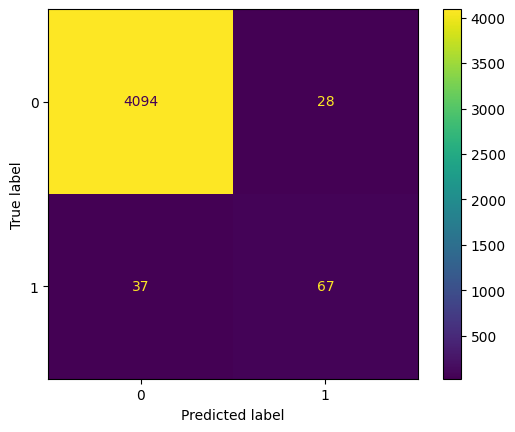

In [38]:
# Run Tuned SVM model
tuned_SVM = svm.SVC(C=10.0, gamma=0.1, random_state=1)
tuned_SVM.fit(X_res, y_res)

print("TUNED SVM MODEL")
report(tuned_SVM)

The basic Random Forest Classifier (with 300 estimators) performed the best with a macro F1 score of 0.88. It made 1 more correct prediction that the other two Random Forest Classifiers.

I wonder if there was a way to do the resampling more effectively, because the RFC was the only model that did not rely on resampled data, and it performed the best.